In [1]:
import numpy as np
import pandas as pd
import torch.nn.functional as F
import math
from torch.optim import lr_scheduler
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
import torch
import itertools
from torchvision import models
import torch.optim as optim
from matplotlib.ticker import MaxNLocator
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from torch.nn import MaxPool2d
import chainer.links as L
from PIL import Image
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

d:\python\odyn\anak2\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Nie można odnaleźć określonej procedury'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
#based on https://www.kaggle.com/code/ankitjha/practical-deep-learning-using-pytorch

In [2]:
#correct mapping of X and y values

data = np.load('X.npy')
target = np.load('Y.npy')
Y = np.zeros(data.shape[0])
Y[:204] = 9
Y[204:409] = 0
Y[409:615] = 7
Y[615:822] = 6
Y[822:1028] = 1
Y[1028:1236] = 8
Y[1236:1443] = 4
Y[1443:1649] = 3
Y[1649:1855] = 2
Y[1855:] = 5
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size = .02, random_state = 2)

In [3]:
X_train.shape, y_train.shape

((2020, 64, 64), (2020,))

In [7]:
#process data

class DatasetProcessing(Dataset):
    
    #initialise the class variables - transform, data, target
    def __init__(self, data, target, transform=None): 
        self.transform = transform
        self.data = data.reshape((-1,64,64)).astype(np.float32)[:,:,:,None]
        # converting target to torch.LongTensor dtype
        self.target = torch.from_numpy(target).long() 
    
    #retrieve the X and y index value and return it
    def __getitem__(self, index): 
        return self.transform(self.data[index]), self.target[index]
    
    #returns the length of the data
    def __len__(self): 
        return len(list(self.data))

In [23]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to a common size
    transforms.ToTensor(),        # Convert images to tensors
])

train_dataset = DatasetProcessing(X_train, y_train, transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)

In [9]:
test_dataset = DatasetProcessing(X_test, y_test, transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4)

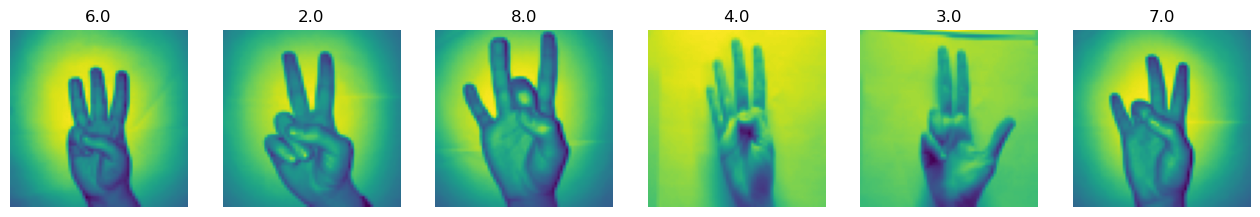

In [12]:
plt.figure(figsize = (16, 4))
for num, x in enumerate(X_train[0:6]):
    plt.subplot(1,6,num+1)
    plt.axis('off')
    plt.imshow(x)
    plt.title(y_train[num])

In [13]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = self.linear_layers(x)
        return F.log_softmax(x)
    

In [14]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [19]:
n_epochs = 100
train_loss = 0
train_accuracy = 0
valid_loss = 0
valid_accuracy = 0

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(epoch):
    model.train()
    exp_lr_scheduler.step()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)  # Corrected variable names and device conversion

        optimizer.zero_grad()
        output = model(inputs)
        pred = torch.max(output.data, 1)[1]
        correct += (pred == targets).sum()  # Corrected variable name
        total += len(inputs)

        loss = criterion(output, targets)

        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        if (batch_idx + 1) % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \t Accuracy: {} %'.format(
                epoch, (batch_idx + 1) * len(inputs), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * correct / total))
            torch.save(model.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')  # Corrected variable name
    train_loss.append(train_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)

In [17]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        output = model(data)
        loss += F.cross_entropy(output, target, size_average=False).item()
        pred = torch.max(output, 1)[1]
        total += len(data)
        correct += (pred == target).sum()

    loss /= len(data_loader.dataset)
    valid_loss.append(loss)
    valid_accuracy.append(100 * correct / float(total))
    print('\nAverage Validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.3f}%)\n'.format(loss, 100 * correct, total, 100 * correct / float(total)))

In [24]:
for epoch in range(n_epochs):
    train(epoch)
    evaluate(test_loader)